In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'walmart-sales-forecast:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2107830%2F3502310%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240302%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240302T015809Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4e15251d695b0aaaab75d813061965a234bae799d3a88923b7a8520469a0012b4b517cc049d74c3338be9cb333fb0cc0926aefd5587c7d7d9a808997dd5b44a81e3ef48945314b5b419d18d771892ac9d93e3cca3bff8e5519761a60faee7312972e6467f71f9f6795b41a4a962c44e663c153a991c3fd1361b7b51bf4efaf04c4a7de30603f0a161cdc60ee15196b5e9d164c84bf0b915c59b83d6effcda9818943b55dd65b8afa8d52da56901c6340cc9754fca2bc8fb6626aeebaed73fd5fff1f74e44f3b4ba2f66de902c6de5ea718fea790c0aa5d803bc163273aea52a7cd52ae0a4658952cf535f78efbd3bf546a4843832c6809d11149f652e3c4f3e0'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3524213 bytes downloaded
Downloaded and uncompressed: walmart-sales-forecast
Data source import complete.


# Time Series Analysis and Forecasting

## Gathering Data and Imports

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/walmart-sales-forecast/stores.csv
/kaggle/input/walmart-sales-forecast/test.csv
/kaggle/input/walmart-sales-forecast/train.csv
/kaggle/input/walmart-sales-forecast/features.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Installing Spark and Creating Spark session

In [4]:
# Installing pyspark
!pip install pyspark
import pyspark.sql.functions as f
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Time Series analysis').getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=ff980d359352104ed5bfe12c56ab69013b4af3f433836d79fc33756d2a78d7c0
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


### Loading the Train.csv Dataset into a spark DataFrame

In [5]:
df = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/kaggle/input/walmart-sales-forecast/train.csv')
df.limit(3).toPandas().style.hide(axis="index")

Store,Dept,Date,Weekly_Sales,IsHoliday
1,1,2010-02-05,24924.500000,False
1,1,2010-02-12,46039.490000,True
1,1,2010-02-19,41595.550000,False


In [6]:
mn_dt = df.select('Date').agg(f.min('Date')).collect()[0][0]
mx_dt = df.select('Date').agg(f.max('Date')).collect()[0][0]
print('Total Rows: ',df.count())
print('Min Date: ', mn_dt)
print('Max Date: ', mx_dt)

Total Rows:  421570
Min Date:  2010-02-05
Max Date:  2012-10-26


#### Loading Stores.csv into a dataframe

In [7]:
stores = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/kaggle/input/walmart-sales-forecast/stores.csv')
stores.limit(3).toPandas().style.hide(axis="index")

Store,Type,Size
1,A,151315
2,A,202307
3,B,37392


In [8]:
print('Total Rows: ', stores.count())
print('Total Stores: ', stores.select('Store').distinct().count())
stores.select('Type').distinct().show()

Total Rows:  45
Total Stores:  45
+----+
|Type|
+----+
|   B|
|   C|
|   A|
+----+



#### Loading features.csv into a dataframe

In [9]:
features = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/kaggle/input/walmart-sales-forecast/features.csv')
features.limit(3).toPandas().style.hide(axis="index")

Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
1,2010-02-05,42.310000,2.572000,NA,NA,NA,NA,NA,211.0963582,8.106,False
1,2010-02-12,38.510000,2.548000,NA,NA,NA,NA,NA,211.2421698,8.106,True
1,2010-02-19,39.930000,2.514000,NA,NA,NA,NA,NA,211.2891429,8.106,False


In [10]:
mn_dt = features.select('Date').agg(f.min('Date')).collect()[0][0]
mx_dt = features.select('Date').agg(f.max('Date')).collect()[0][0]
print('Total Rows: ',features.count())
print('Min Date: ', mn_dt)
print('Max Date: ', mx_dt)

Total Rows:  8190
Min Date:  2010-02-05
Max Date:  2013-07-26


#### Joining entire dataset to make features

In [11]:
# Converting 'NA' strings in MarkDown columns to null values
for i in range(1,6):
    features = features.withColumn(
        f'MarkDown{i}', f.when(f.col(f'MarkDown{i}')=='NA', None).otherwise(
            f.col(f'MarkDown{i}')).cast('float'))

In [12]:
pdf = df.join(
    stores, on='Store', how='inner').join(
    features.drop('IsHoliday'), on=['Date','Store'], how='left').toPandas()
pdf['Date'] = pd.to_datetime(pdf['Date'])
pdf.set_index('Date', inplace=True)
pdf["CPI"] = pd.to_numeric(pdf["CPI"], downcast="float")
pdf["Unemployment"] = pd.to_numeric(pdf["Unemployment"], downcast="float")
pdf.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Date,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096359,8.106
2010-02-12,1,1,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242172,8.106
2010-02-19,1,1,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289139,8.106
2010-02-26,1,1,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319641,8.106
2010-03-05,1,1,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [13]:
pdf.dtypes

Store             int32
Dept              int32
Weekly_Sales    float64
IsHoliday          bool
Type             object
Size              int32
Temperature     float64
Fuel_Price      float64
MarkDown1       float32
MarkDown2       float32
MarkDown3       float32
MarkDown4       float32
MarkDown5       float32
CPI             float32
Unemployment    float32
dtype: object

## Visualizations

#### Stores Data

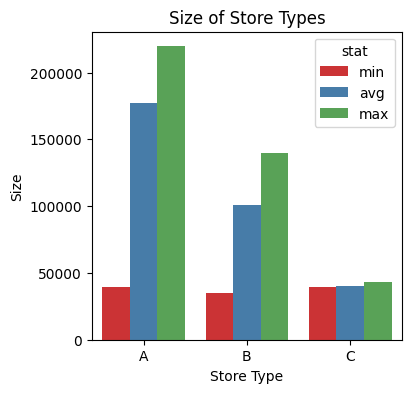

In [14]:
# Checking min, max, average of store by Type
stdf = stores.groupBy('Type').agg(
    f.min('Size').alias('min'),
    f.round(f.avg('Size'),2).alias('avg'),
    f.max('Size').alias('max')).orderBy('Type').toPandas()

m_df = pd.melt(stdf, id_vars="Type", var_name="stat", value_name="Size")
fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(x='Type', y='Size', hue='stat', data=m_df, ax=ax, palette='Set1').set_title('Size of Store Types')
plt.xlabel('Store Type')
plt.show()

#### Observations
- Type 'A' are the biggest store types with highest 'max' and 'average'  
- Type 'C' are the smallest stores with lowest 'max' and 'average'    
- Type 'B' average store size is in the middle  
- But the Minimun store size is close for all the store types  

#### Sales Data

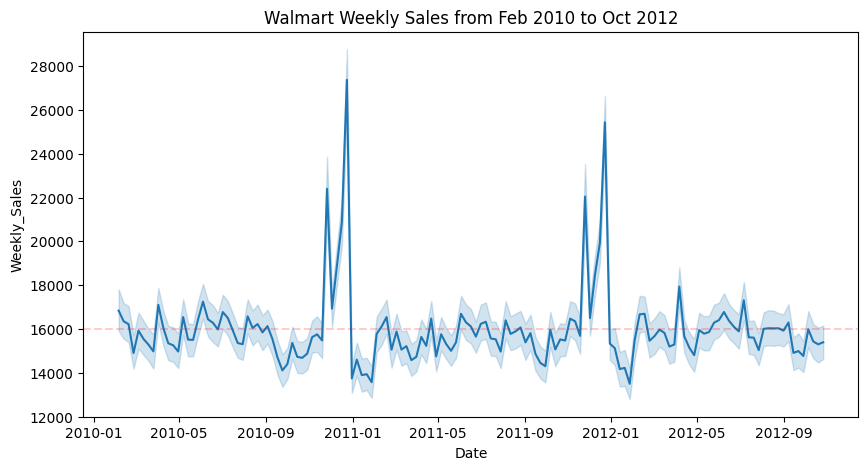

In [15]:
plt.figure(figsize=(10,5))
sns.lineplot(data=pdf,
             x='Date',
             y='Weekly_Sales',
            ).set_title('Walmart Weekly Sales from Feb 2010 to Oct 2012')
plt.axhline(pdf['Weekly_Sales'].mean(), color='r', alpha=0.2, linestyle='--')
plt.show()

#### Observations
- We see a spike in Sales during the holiday season (November to December) every year  
- The spike was highest on 2011  
- Average sales moves around 16000$ for the rest of the Months  

#### Taking a closer look at the Spike

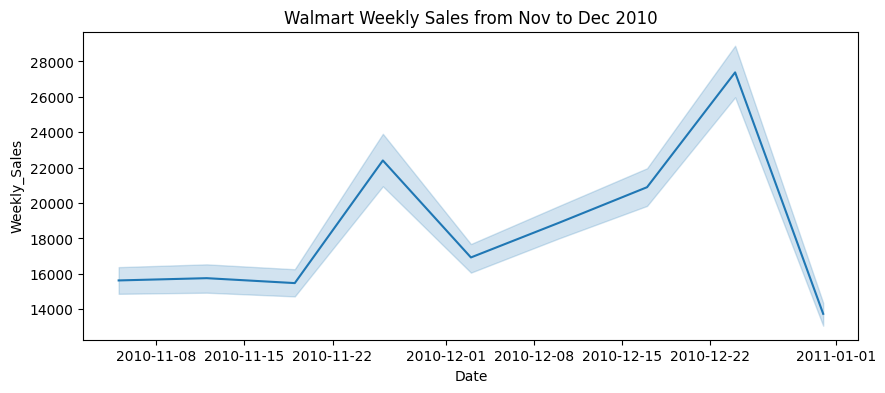

In [16]:
plt.figure(figsize=(10,4))
sns.lineplot(
    data=pdf.loc[(pdf.index >'2010-11-01') & (pdf.index<'2011-01-01')],
    x='Date', y='Weekly_Sales'
    ).set_title('Walmart Weekly Sales from Nov to Dec 2010')
plt.show()

**The spike is seen during ThanksGiving (23-Nov) Black Friday(24-Nov) and Christmas (25-Dec)**

### Analyzing Sales by Month, Quarter, Year

In [17]:
pdf['Day'] = pdf.index.day
pdf['Month'] = pdf.index.month
pdf['Quarter'] = pdf.index.quarter
pdf['Year'] = pdf.index.year

<ipython-input-18-51dec4516721>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pdf.loc[(pdf.index >'2011-01-01') & (pdf.index<'2011-12-31')], x='Month', y='Weekly_Sales',


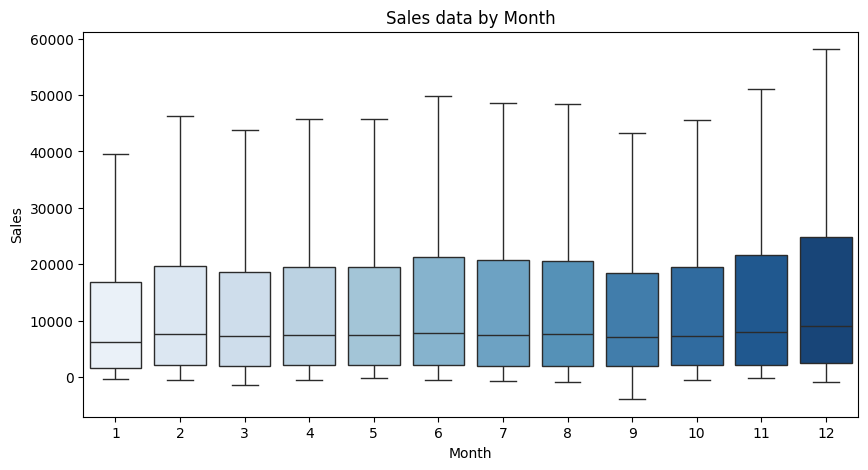

In [18]:
plt.figure(figsize=(10,5))
sns.boxplot(data=pdf.loc[(pdf.index >'2011-01-01') & (pdf.index<'2011-12-31')], x='Month', y='Weekly_Sales',
            palette='Blues', showfliers=False
           ).set_title('Sales data by Month')
plt.ylabel('Sales')
plt.show()

- We can see the increase in sales in Nov(11) and December(12)  
- June(6) also has slightly higher sales  
- January(1) sales are lowest, it can be due to people avoiding shopping just after the holiday season  

<ipython-input-19-52ce5d04cfc5>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pdf.loc[(pdf.index >'2011-01-01') & (pdf.index<'2011-12-31')], x='Quarter', y='Weekly_Sales',


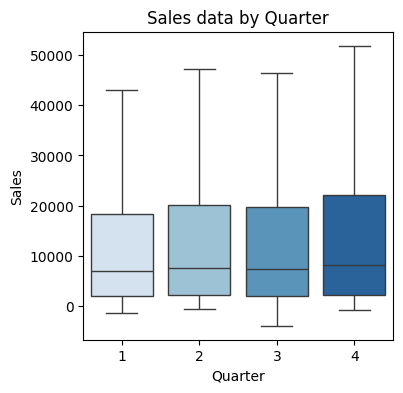

In [19]:
plt.figure(figsize=(4,4))
sns.boxplot(data=pdf.loc[(pdf.index >'2011-01-01') & (pdf.index<'2011-12-31')], x='Quarter', y='Weekly_Sales',
            palette='Blues', showfliers=False
           ).set_title('Sales data by Quarter')
plt.ylabel('Sales')
plt.show()

**Q4 has the highest sales due to holiday season**

<ipython-input-20-3e6635473dc7>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pdf, x='Year', y='Weekly_Sales',


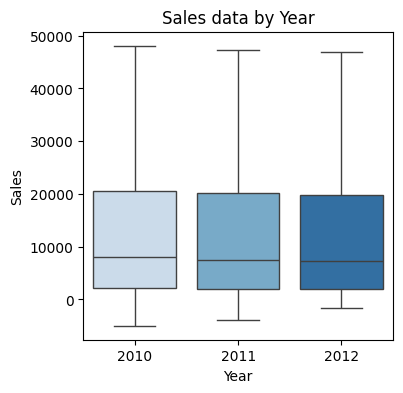

In [20]:
plt.figure(figsize=(4,4))
sns.boxplot(data=pdf, x='Year', y='Weekly_Sales',
            palette='Blues', showfliers=False
           ).set_title('Sales data by Year')
plt.ylabel('Sales')
plt.show()

**We see a decrease in Sales from 2010 to 2012, It can happen due to the following reasons:**  
- We dont have sales of Nov and Dec in 2012  
- We also dont have sales of Jan in 2010 (which might make the avg a little higher than 2011)  

<ipython-input-21-f8b0aa8dffee>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pdf.loc[pdf.index.month.isin([2,3,4,5,6,7,8,9,10])], x='Year', y='Weekly_Sales',


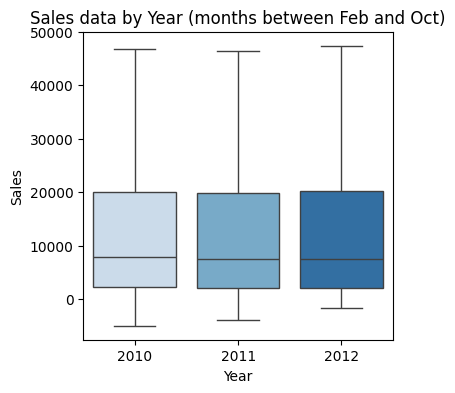

In [21]:
plt.figure(figsize=(4,4))
sns.boxplot(data=pdf.loc[pdf.index.month.isin([2,3,4,5,6,7,8,9,10])], x='Year', y='Weekly_Sales',
            palette='Blues', showfliers=False
           ).set_title('Sales data by Year (months between Feb and Oct)')
plt.ylabel('Sales')
plt.show()


**Taking data of Months Feb-Oct as they are available for all years**  
- We can see the sales is not decreasing over the years

<ipython-input-22-fb602c8b9990>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pdf, x='IsHoliday', y='Weekly_Sales',


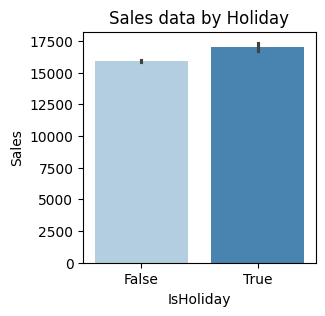

In [22]:
plt.figure(figsize=(3,3))
sns.barplot(data=pdf, x='IsHoliday', y='Weekly_Sales',
            palette='Blues', #showfliers=False
           ).set_title('Sales data by Holiday')
plt.ylabel('Sales')
plt.show()

**Sales are slightly higher during Holidays**

### Analyzing Store Types with Sales

<ipython-input-23-b29283bce2fe>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pdf, x='Type', y='Weekly_Sales',


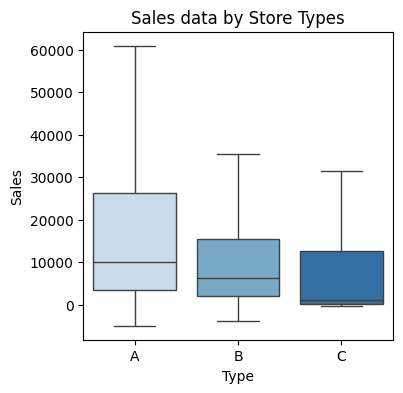

In [23]:
plt.figure(figsize=(4,4))
sns.boxplot(data=pdf, x='Type', y='Weekly_Sales',
            palette='Blues' , showfliers=False
           ).set_title('Sales data by Store Types')
plt.ylabel('Sales')
plt.show()

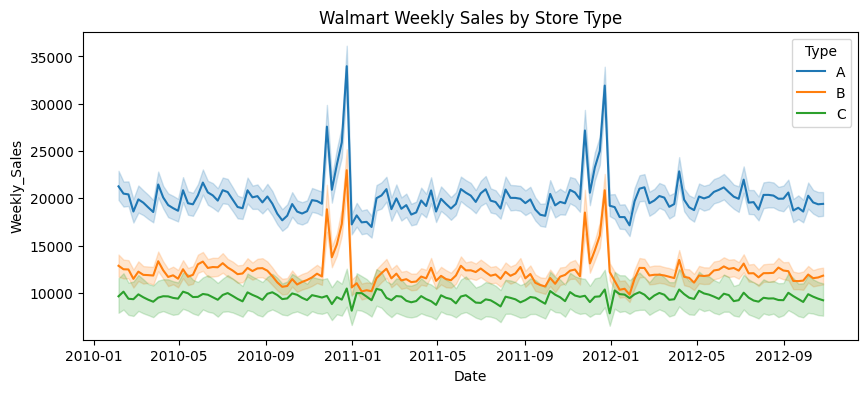

In [24]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf,
             x='Date',
             y='Weekly_Sales',
             hue='Type'
            ).set_title('Walmart Weekly Sales by Store Type')
plt.show()

**Bigger stores (A) have higher sales compared to smaller stores (B)**

### Analyzing additional Features with Sales

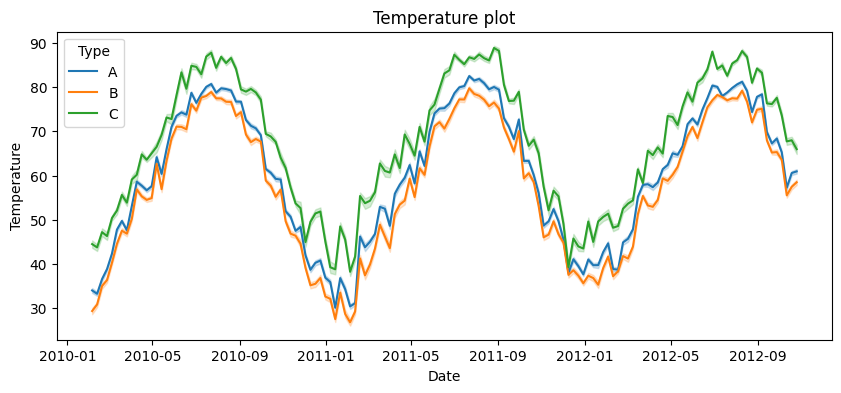

In [25]:
fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(data=pdf,
             x='Date',
             y='Temperature',
             hue='Type',
             ax=ax,
            ).set_title('Temperature plot')
plt.show()

- Temperature around Type C stores (small stores) is high compared to other stores

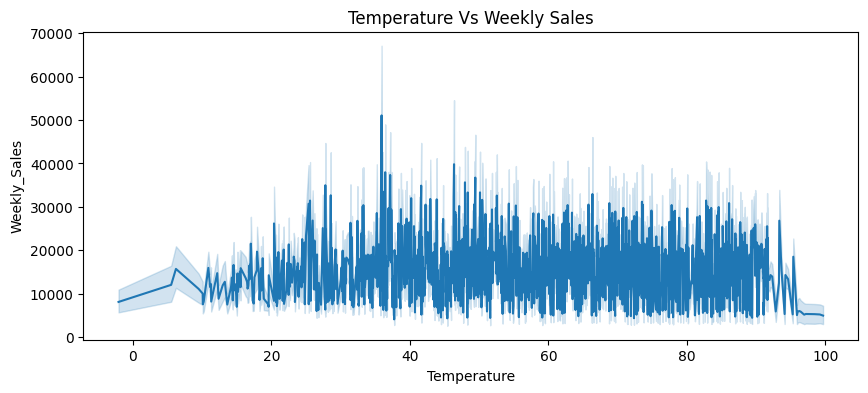

In [26]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf.loc[(pdf.index >'2011-01-01') & (pdf.index<'2011-12-31')],
             x='Temperature',
             y='Weekly_Sales',
            ).set_title('Temperature Vs Weekly Sales')
plt.show()

**There is no effect of Temperature on Sales**

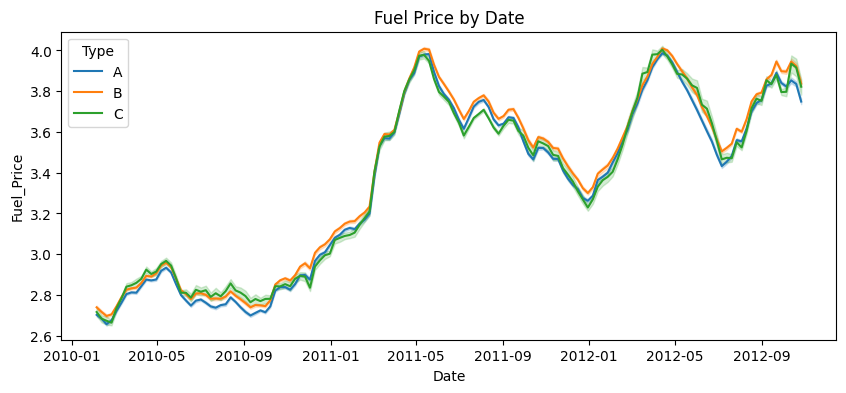

In [27]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf,
             x='Date',
             y='Fuel_Price',
             hue='Type',
            ).set_title('Fuel Price by Date')
plt.show()

**Fuel price is identical for all store types**

In [28]:
pdf['Fuel_Price_Change'] = pdf['Fuel_Price'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0)

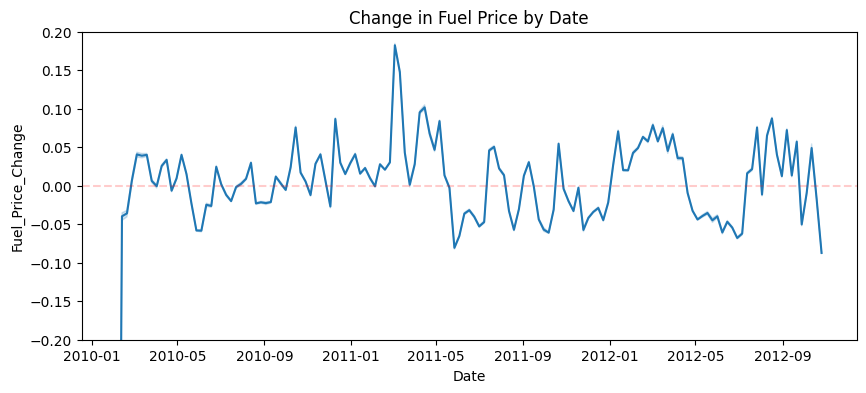

In [29]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf,
             x='Date',
             y='Fuel_Price_Change',
             #hue='Type',
            ).set_title('Change in Fuel Price by Date')
plt.axhline(pdf['Fuel_Price_Change'].mean(), color='r', alpha=0.2, linestyle='--')
plt.ylim(-0.2, 0.2)
plt.show()

**The shift (Change) in fuel price moves around randomly with the mean of 0**

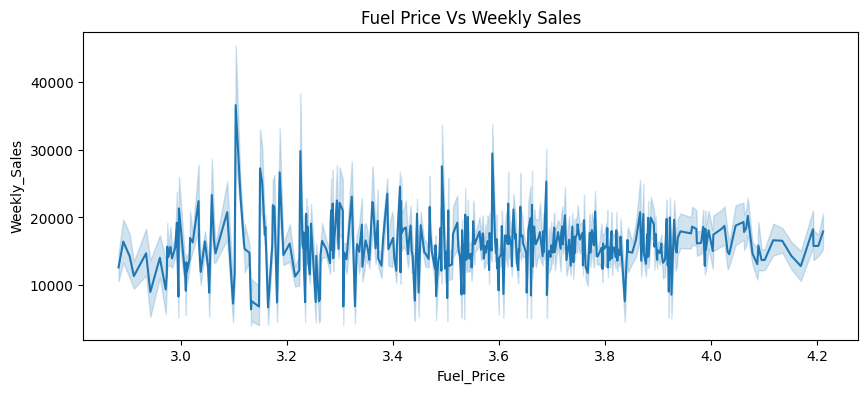

In [30]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf.loc[(pdf.index >'2011-01-01') & (pdf.index<'2011-12-31')],
             x='Fuel_Price',
             y='Weekly_Sales',
            ).set_title('Fuel Price Vs Weekly Sales')
plt.show()

**There is no effect of Fuel Price of the region on Sales**

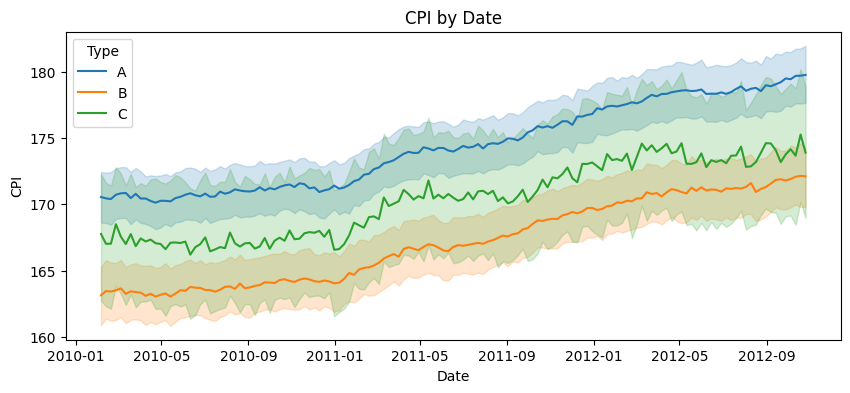

In [31]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf,
             x='Date',
             y='CPI',
             hue='Type'
            ).set_title('CPI by Date')
plt.show()

- Overall CPI (Consumer Price Index) is increase over time  
- Type A stores have highest CPI index  
- Type C stores have higher CPI index than Type B stores  

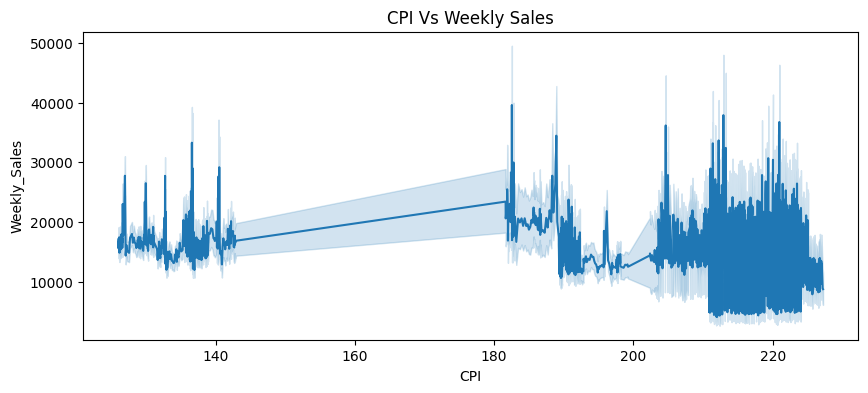

In [32]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf,
             x='CPI',
             y='Weekly_Sales',
            ).set_title('CPI Vs Weekly Sales')
plt.show()

**There is no effect of CPI (Consumer Price Index) on sales**

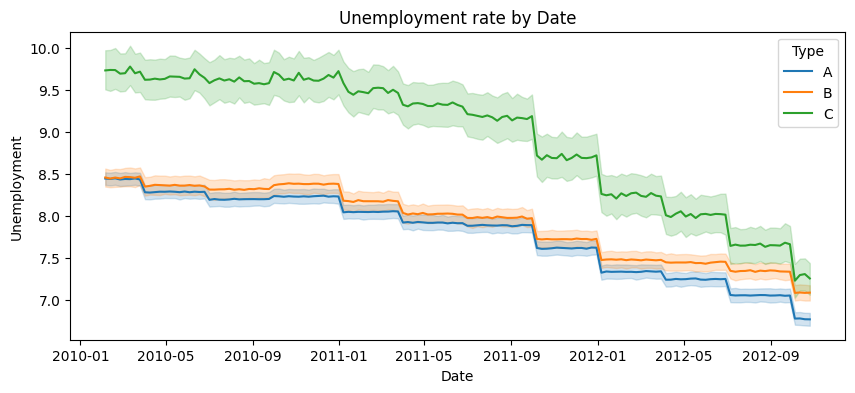

In [33]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf,
             x='Date',
             y='Unemployment',
             hue='Type',
            ).set_title('Unemployment rate by Date')
plt.show()

- Unemployment Rate is descending over time
- Unemployment Rate is highest around Type C stores (small stores), they could be around rural areas
- Unemployment is similar around Type A and B stores

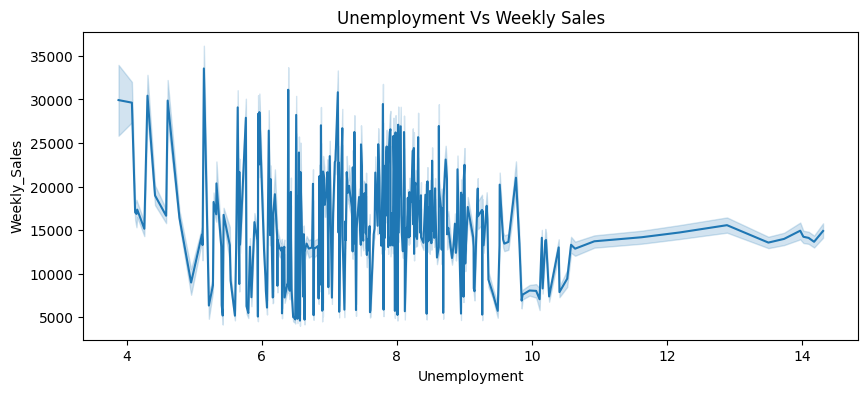

In [34]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf,
             x='Unemployment',
             y='Weekly_Sales',
            ).set_title('Unemployment Vs Weekly Sales')
plt.show()

**There is no effect of Unemployment on sales**

## Outlier Analysis

- There are several ways to treat outliers in a dataset, depending on the nature of the outliers and the problem being solved.  
- We will use **Capping** Technique to handle outliers.  
- First We will visualize the distribution of the data
- Then we will decide the values for capping

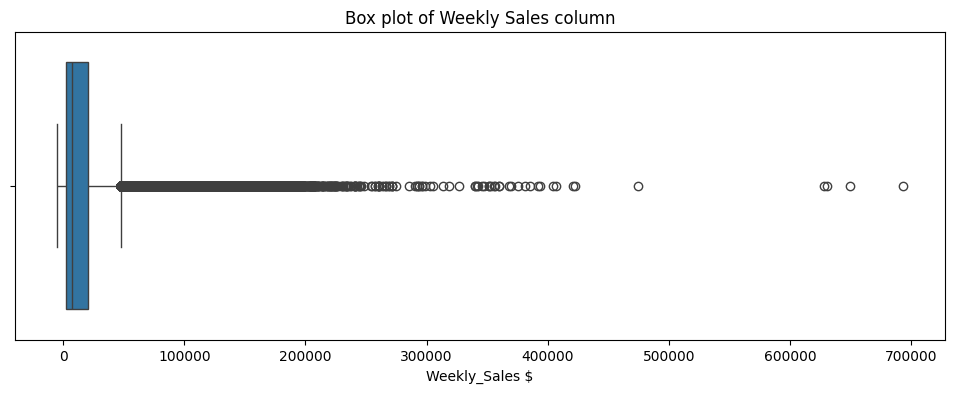

In [35]:
plt.figure(figsize=(12,4))
sns.boxplot(pdf['Weekly_Sales'], orient='h')
plt.xlabel('Weekly_Sales $')
plt.title('Box plot of Weekly Sales column')
plt.show()

The data has large gaps after 200000

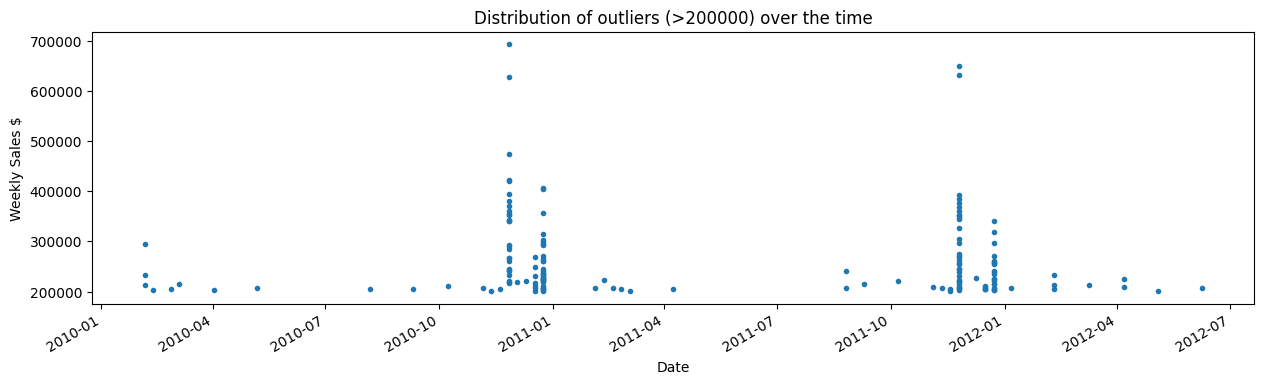

In [36]:
pdf.query('Weekly_Sales > 200000')['Weekly_Sales'].plot(figsize=(15,4), style='.')
plt.ylabel('Weekly Sales $')
plt.title('Distribution of outliers (>200000) over the time')
plt.show()

Throughout the year, we have some positive outliers (sales more than 200000 $)
  
Now looking at Negative values

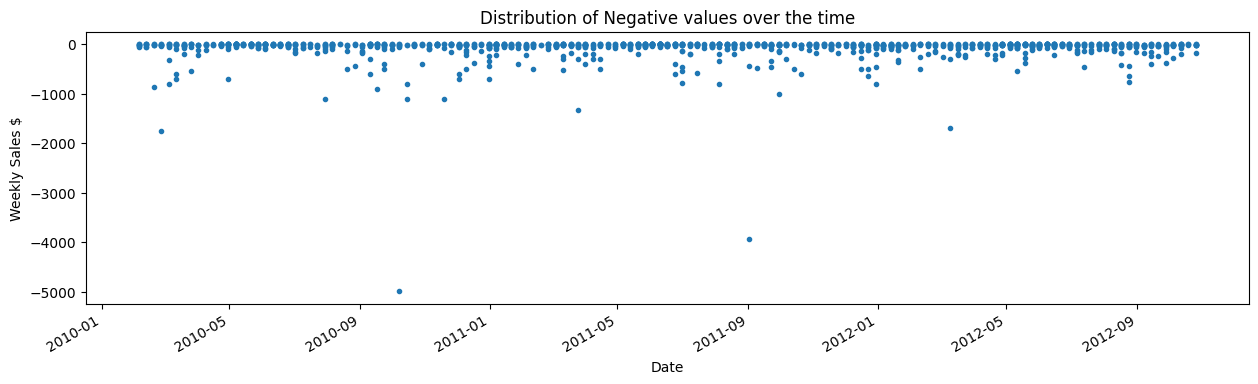

In [37]:
pdf.query('Weekly_Sales < 0')['Weekly_Sales'].plot(figsize=(15,4), style='.')
plt.ylabel('Weekly Sales $')
plt.title('Distribution of Negative values over the time')
plt.show()

**We will remove these outliers before trainig the model**

In [38]:
old_count = pdf.shape[0]
print('Dataset_size before removing outliers: ', old_count)
pdf = pdf.query('Weekly_Sales >= 0 and Weekly_Sales < 200000')
new_count = pdf.shape[0]
print('Dataset_size after removing outliers: ', pdf.shape[0])
print('Percent decrease in data: ', round((old_count - new_count)*100/old_count,2))

Dataset_size before removing outliers:  421570
Dataset_size after removing outliers:  420122
Percent decrease in data:  0.34


Only 0.34 % of the data was removed

## Correlation Matrix

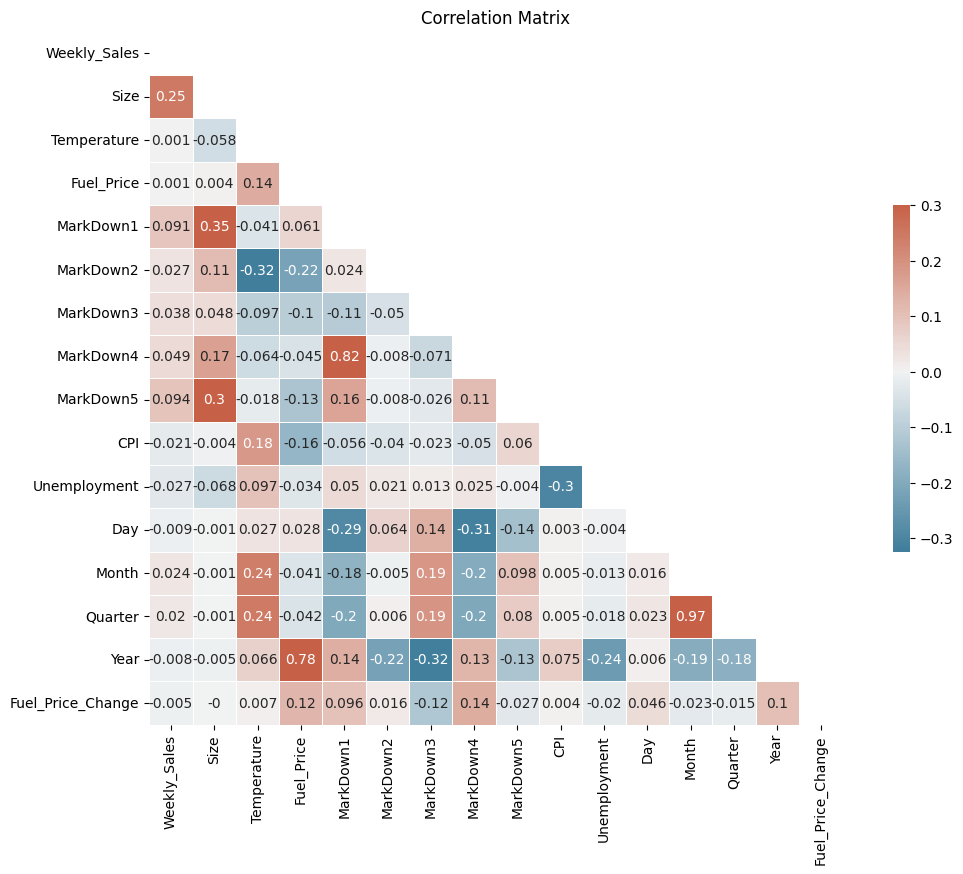

In [39]:
# Numerical cols
num_cols = [x for x in pdf.columns if x not in ['Type','IsHoliday','Dept','Store']]

# Compute the correlation matrix
corr = pdf[num_cols].corr().round(3)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix')
plt.show()

- MarkDown4 and MarkDown1 have high correlation  
- MarkDown1 and MarkDown5 have positive correlation with Size  
    - They could be exclusive offers for bigger stores  
- MarkDown2 have negative correlation with Temperature  
    - MarkDown2 could be offers during winters / holiday offers  

## Pre Processing Data

In [40]:
!pip install xgboost

## Joining Datasets and Creating features

In [42]:
from pyspark.sql.functions import when, col


In [44]:
df = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/kaggle/input/walmart-sales-forecast/train.csv')
stores = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/kaggle/input/walmart-sales-forecast/stores.csv')
features = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/kaggle/input/walmart-sales-forecast/features.csv')
# Converting 'NA' strings in MarkDown columns to null values
for i in range(1, 6):
    features = features.withColumn(
        f'MarkDown{i}',
        when(col(f'MarkDown{i}') == 'NA', None).otherwise(col(f'MarkDown{i}')).cast('float')
    )

pdf = df.join(
    stores, on='Store', how='inner').join(
    features.drop('IsHoliday'), on=['Date','Store'], how='left').toPandas()
pdf['Date'] = pd.to_datetime(pdf['Date'])
pdf.set_index('Date', inplace=True)
pdf["CPI"] = pd.to_numeric(pdf["CPI"], downcast="float")
pdf["Unemployment"] = pd.to_numeric(pdf["Unemployment"], downcast="float")
pdf['Day'] = pdf.index.day
pdf['Week'] = np.ceil(pdf.index.dayofyear/7).astype(int)
pdf['Month'] = pdf.index.month
pdf['Quarter'] = pdf.index.quarter
pdf['Year'] = pdf.index.year
pdf = pdf.query('Weekly_Sales >= 0 and Weekly_Sales < 200000')
pdf.head().style.hide(axis="index")

Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Day,Week,Month,Quarter,Year
1,1,24924.500000,False,A,151315,42.310000,2.572000,nan,nan,nan,nan,nan,211.096359,8.106000,5,6,2,1,2010
1,1,46039.490000,True,A,151315,38.510000,2.548000,nan,nan,nan,nan,nan,211.242172,8.106000,12,7,2,1,2010
1,1,41595.550000,False,A,151315,39.930000,2.514000,nan,nan,nan,nan,nan,211.289139,8.106000,19,8,2,1,2010
1,1,19403.540000,False,A,151315,46.630000,2.561000,nan,nan,nan,nan,nan,211.319641,8.106000,26,9,2,1,2010
1,1,21827.900000,False,A,151315,46.500000,2.625000,nan,nan,nan,nan,nan,211.350143,8.106000,5,10,3,1,2010


## Handling Missing values

In [45]:
pdf.isnull().sum()

Store                0
Dept                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       269992
MarkDown2       309270
MarkDown3       283525
MarkDown4       285656
MarkDown5       269244
CPI                  0
Unemployment         0
Day                  0
Week                 0
Month                0
Quarter              0
Year                 0
dtype: int64

- **Only MarkDown columns have missing values.**  
- As they are anonimized offer related sales. We can assume if there is no data (NaN) for a particular day then the value is 0.  
- So we can replace nulls with 0.  

In [46]:
pdf.fillna(0, inplace=True)

## Converting String / Boolean Columns into Numerical

Converting **"Is Holiday"** column to int  
Changing the type will replace True -> 1 and False -> 0  

In [47]:
# Converting Is Holiday column to int
# Changing the type will replace True -> 1 and False -> 0
pdf['IsHoliday'] = pdf['IsHoliday'].astype('int')

Converting **Type of store** into numerical  
We will use the order of size to decide the numerical values for store types  
As we have seen Type **A stores are largest and C are smallest**,   
we will use the following mapping  
**C-> 0, B-> 1, A-> 2**

In [48]:
# Converting Type of store into numerical
# We will use the order of size to decide the numerical values for store types
# As we have seen Type A stores are largest and C are smallest,
# we will use the following mapping
# C-> 0, B-> 1, A-> 2

pdf['Type'] = pdf['Type'].replace({'C': 0, 'B': 1, 'A': 2})

## XGBoost Model

In [49]:
TARGET = ['Weekly_Sales']
FEATURES = [i for i in pdf.columns if i not in TARGET]

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pdf[FEATURES], pdf[TARGET],
                                                   test_size=0.2, random_state=130)

In [51]:
import xgboost as xgb
reg = xgb.XGBRegressor(n_estimators=2000, early_stopping_rounds=50,
                      learning_rate=0.5)
model = reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=100)

[0]	validation_0-rmse:15063.79170	validation_1-rmse:15139.93328
[100]	validation_0-rmse:4242.24583	validation_1-rmse:4492.70623
[200]	validation_0-rmse:3482.17459	validation_1-rmse:3878.64994
[300]	validation_0-rmse:3087.08542	validation_1-rmse:3587.85615
[400]	validation_0-rmse:2811.11912	validation_1-rmse:3408.92916
[500]	validation_0-rmse:2608.76790	validation_1-rmse:3287.69013
[600]	validation_0-rmse:2453.39392	validation_1-rmse:3205.62576
[700]	validation_0-rmse:2334.43202	validation_1-rmse:3135.30009
[800]	validation_0-rmse:2237.46742	validation_1-rmse:3089.50207
[900]	validation_0-rmse:2146.26464	validation_1-rmse:3049.58338
[1000]	validation_0-rmse:2069.41808	validation_1-rmse:3019.87896
[1100]	validation_0-rmse:2000.64612	validation_1-rmse:2989.92329
[1200]	validation_0-rmse:1937.12835	validation_1-rmse:2962.81252
[1300]	validation_0-rmse:1882.34812	validation_1-rmse:2942.05732
[1400]	validation_0-rmse:1837.24162	validation_1-rmse:2926.77431
[1500]	validation_0-rmse:1783.89858

In [81]:
date_range = pd.date_range(start='2022-05-04', end='2023-05-06', freq='W-FRI')

# Tạo một DataFrame với các ngày trong dải ngày đã cho
A_val = pd.DataFrame(index=date_range)

# Điền các cột cần thiết của X_val với các giá trị mặc định hoặc giá trị bạn mong muốn
A_val['Store'] = 1  # Giả sử tất cả các mẫu thuộc cửa hàng có ID là 1
A_val['Dept'] = 1   # Giả sử tất cả các mẫu thuộc phòng ban có ID là 1
A_val['IsHoliday'] = 0  # Giả sử không có ngày nào là ngày lễ
A_val['Type'] = 2  # Giả sử tất cả các cửa hàng thuộc loại có ID là 2
A_val['Size'] = 151315  # Kích thước cửa hàng, có thể giữ nguyên hoặc thay đổi theo mẫu dữ liệu của bạn
A_val['Temperature'] = 75.55  # Nhiệt độ, có thể giữ nguyên hoặc thay đổi theo mẫu dữ liệu của bạn
A_val['Fuel_Price'] = 3.749  # Giá nhiên liệu, có thể giữ nguyên hoặc thay đổi theo mẫu dữ liệu của bạn
A_val['MarkDown1'] = 21290.130859
A_val['MarkDown2'] = 0  # Giả sử không có MarkDown2 trong khoảng thời gian này
A_val['MarkDown3'] = 0  # Giả sử không có MarkDown3 trong khoảng thời gian này
A_val['MarkDown4'] = 0  # Giả sử không có MarkDown4 trong khoảng thời gian này
A_val['MarkDown5'] = 0  # Giả sử không có MarkDown5 trong khoảng thời gian này
A_val['CPI'] = 221.7    # Giả sử chỉ số CPI trong khoảng thời gian này là 221.7
A_val['Unemployment'] = 7.0  # Giả sử tỷ lệ thất nghiệp trong khoảng thời gian này là 7.0%
A_val['Day'] = A_val.index.day  # Lấy ngày từ chỉ mục của DataFrame
A_val['Week'] = A_val.index.week  # Lấy tuần từ chỉ mục của DataFrame
A_val['Month'] = A_val.index.month  # Lấy tháng từ chỉ mục của DataFrame
A_val['Quarter'] = A_val.index.quarter  # Lấy quý từ chỉ mục của DataFrame
A_val['Year'] = A_val.index.year  # Lấy năm từ chỉ mục của DataFrame

<ipython-input-81-406e1f420230>:22: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  A_val['Week'] = A_val.index.week  # Lấy tuần từ chỉ mục của DataFrame


In [82]:
y_pred = reg.predict(A_val)

In [83]:
print(y_pred)

[20314.617 18601.059 16451.66  17382.11  19387.498 19069.184 17428.592
 17274.51  18614.658 18203.988 18084.035 19765.996 17220.885 19726.36
 18986.43  17637.719 17878.043 18506.135 20844.545 18017.432 17327.928
 19750.64  21503.854 19745.63  21241.37  31395.828 39971.406 30391.781
 21054.686 27908.742 26144.922 26517.896 47546.812 58678.348 58333.938
 25943.057 29150.996 28980.395 28206.076 26492.584 27787.32  38748.883
 18170.52  18170.125 19504.174 19712.54  22966.955 26578.7   28550.85
 33116.727 30343.37  29747.314 20496.018]


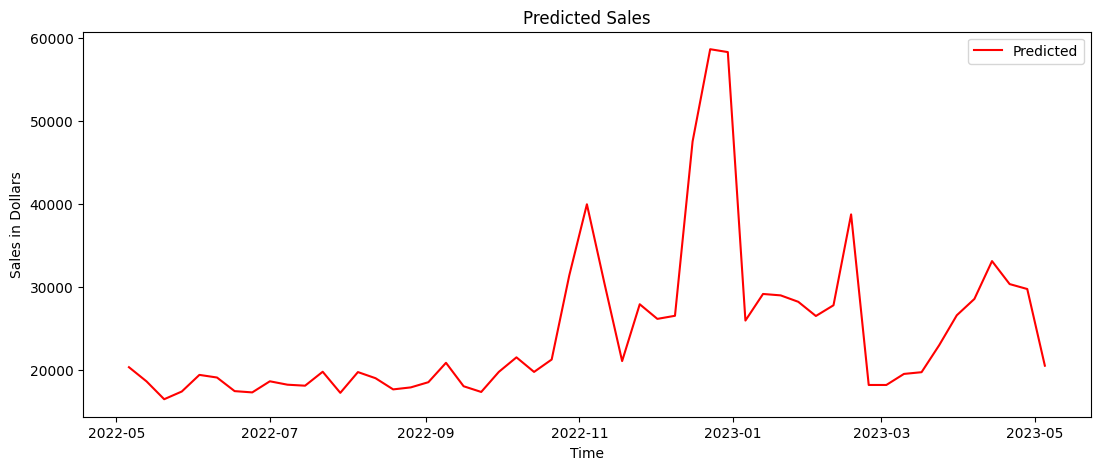

In [84]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ
plt.figure(figsize=(13, 5))
plt.plot(A_val.index, y_pred, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Sales in Dollars')
plt.title('Predicted Sales')
plt.legend()
plt.show()


In [55]:
from sklearn import metrics  # Thêm dòng này để import 'metrics'

In [57]:
xgboost_accuracy = reg.score(X_test,y_test)*100
print("XGB Regressor Evaluation Metrics: ")
print("Accuracy", round(xgboost_accuracy,3))
print("MAE \t" , round(metrics.mean_absolute_error(y_test, y_pred),3))
print("MSE \t" , round(metrics.mean_squared_error(y_test, y_pred),3))
print("RMSE \t" , round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),3))
print("R2 \t" , round(metrics.explained_variance_score(y_test, y_pred),5))

XGB Regressor Evaluation Metrics: 
Accuracy 98.348
MAE 	 1570.744
MSE 	 8134464.931
RMSE 	 2852.098
R2 	 0.98348


In [58]:
print('Top 10 features with their Feature importance scores: ')
pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=['Feature Importance']).sort_values('Feature Importance', ascending=False).head(10)

Top 10 features with their Feature importance scores: 


,Feature Importance
Size,0.349576
Dept,0.214630
Type,0.146933
Store,0.098718
CPI,0.038189
Week,0.030618
IsHoliday,0.024891
Month,0.023361
Year,0.019829
Unemployment,0.011220


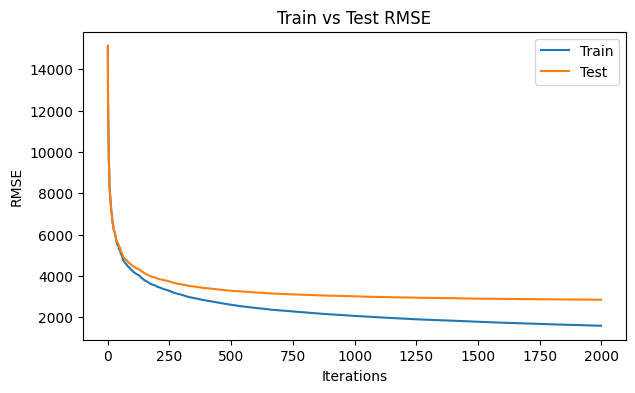

In [59]:
fig, ax = plt.subplots(1,1,figsize=(7,4))
score_hist = pd.DataFrame({'Train_rmse':model.evals_result()['validation_0']['rmse'], 'Test_rmse':model.evals_result()['validation_1']['rmse']})
sns.lineplot(score_hist['Train_rmse'], ax=ax, label='Train')
sns.lineplot(score_hist['Test_rmse'], ax=ax, label='Test')
plt.ylabel('RMSE')
plt.xlabel('Iterations')
plt.title('Train vs Test RMSE')
plt.show()

In [60]:
val = pdf.loc[pdf.index >= '2012-05-01']
X_val, y_val = val[FEATURES], val[TARGET]
val['prediction'] = reg.predict(X_val)

<ipython-input-60-315f3b7bbeb8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['prediction'] = reg.predict(X_val)


In [85]:
import joblib

# Đường dẫn để lưu mô hình
MODEL_PATH = '/content/sample_data/predict.pkl'

# Lưu mô hình
joblib.dump(reg, MODEL_PATH)

['/content/sample_data/predict.pkl']

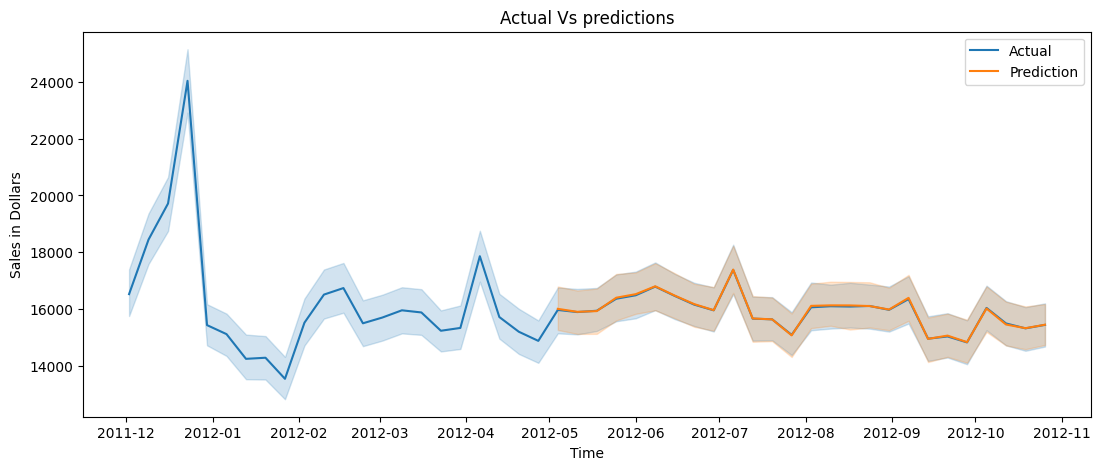

In [61]:
fig, ax = plt.subplots(1,1,figsize=(13,5))
sns.lineplot(pdf['Weekly_Sales'].loc[pdf.index>'2011-12-01'], ax=ax, label='Actual')
sns.lineplot(val['prediction'], ax=ax, label='Prediction')
plt.ylabel('Sales in Dollars')
plt.xlabel('Time')
plt.title('Actual Vs predictions')
plt.show()

The Predictions are pretty close to the actual values as we have a **accuracy of 98%**

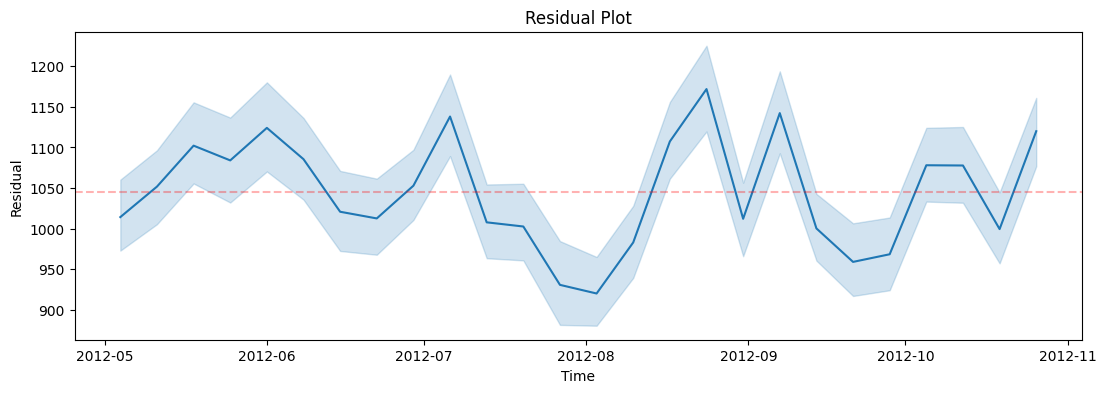

In [62]:
val = val.assign(Residual= abs(val['Weekly_Sales'] - val['prediction']))
fig, ax = plt.subplots(1,1,figsize=(13,4))
#sns.lineplot(pdf['Weekly_Sales'].loc[pdf.index>'2011-12-01'], ax=ax, label='Actual')
sns.lineplot(val['Residual'], ax=ax)
plt.axhline(val['Residual'].mean(), linestyle='--', color='r', alpha=0.3)
#plt.ylabel('Sales in Dollars')
plt.xlabel('Time')
plt.title('Residual Plot')
plt.show()

The residuals are close to the MAE

## Predicting Overall sales per day using SARIMA Model

#### Preparing Dataset (cumulating sales for all stores)

In [63]:
cum_pdf = pdf['Weekly_Sales'].groupby('Date').sum().to_frame(name='Weekly_Sales')

In [64]:
train = cum_pdf.loc[cum_pdf.index < '2012-05-01']
test = cum_pdf.loc[cum_pdf.index >= '2012-05-01']

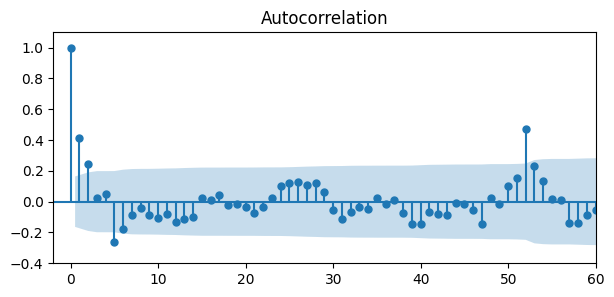

In [65]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(7,3))
acf_plot = plot_acf(cum_pdf.Weekly_Sales, lags=100, ax=ax)
plt.ylim(-0.4, 1.1)
plt.xlim(-2,60)
plt.show()

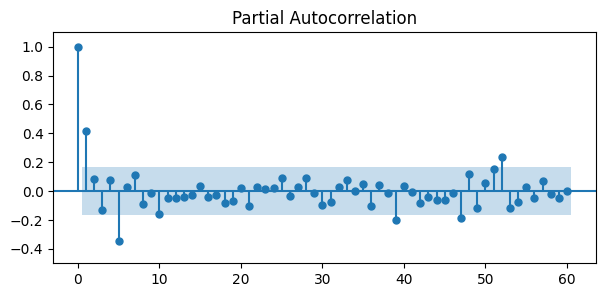

In [66]:
fig, ax = plt.subplots(figsize=(7,3))
pacf_plot = plot_pacf(cum_pdf.Weekly_Sales, lags=60, ax=ax)
plt.ylim(-0.5, 1.1)
plt.show()

**Based on PACF, we should start with Auto Regressive(AR) model with lags 1,2,5,52**

### AD-Fuller Test

In [67]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(cum_pdf.Weekly_Sales)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -6.357042012534244
p-value: 2.527814798229619e-08


As the p-value is less than 0.05 and ADF statistic is a negative number  
**The Time series is Stationary**

In [68]:
import statsmodels.api as sm
order_aic_bic =[]

# Loop over p values from 0-2
for p in [1,2,5,52]:
    # Loop over q values from 0-2
    for q in [1,2,5,52]:

        try:
            # create and fit ARMA(p,q) model
            model = sm.tsa.statespace.SARIMAX(train.Weekly_Sales, order=(p, 0, q))
            results = model.fit(maxiter=100, full_output=False, disp=False)

            # Print order and results
            order_aic_bic.append((p, q, results.aic, results.bic))
        except:
            print(p, q, None, None)

# Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'aic','bic'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  

In [69]:
# lets sort them by AIC and BIC

# Sort by AIC
print("Sorting SARIMA model with different (p,q) by AIC ")
print("\n")
print(order_df.sort_values('aic').reset_index(drop=True))

# Sort by BIC
print("Sorted by BIC ")
print("\n")
print(order_df.sort_values('bic').reset_index(drop=True))

Sorting SARIMA model with different (p,q) by AIC 


     p   q          aic          bic
0   52   5  3879.180295  4039.386383
1   52   2  3882.542525  4034.462092
2   52   1  3882.566934  4031.724326
3    1   5  3920.531866  3939.867084
4    5   5  3925.789982  3956.173895
5    2   1  3930.915414  3941.964110
6    1   2  3937.795438  3948.844134
7    5   2  3939.889030  3961.986422
8    5   1  3942.014748  3961.349966
9    1   1  3942.865561  3951.152083
10   2   2  3945.281683  3959.092553
11   2   5  3972.345789  3994.443180
12   1  52  3981.262006  4130.419398
13   2  52  3982.787185  4134.706752
14   5  52  4001.086178  4161.292266
15  52  52  4060.922827  4350.951090
Sorted by BIC 


     p   q          aic          bic
0    1   5  3920.531866  3939.867084
1    2   1  3930.915414  3941.964110
2    1   2  3937.795438  3948.844134
3    1   1  3942.865561  3951.152083
4    5   5  3925.789982  3956.173895
5    2   2  3945.281683  3959.092553
6    5   1  3942.014748  3961.349966
7    5

p = 1 and q = 5 gives the lowest BIC &  
p = 52 and q = 5 gives the lowest AIC

In [70]:
# The model with the best p and q found from pervious step
import statsmodels.api as sm
model = sm.tsa.statespace.SARIMAX(train.Weekly_Sales, order=(52, 0, 5))
# Fit model
results = model.fit()
# Assign residuals to variable
residuals = results.resid

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [71]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  117
Model:              SARIMAX(52, 0, 5)   Log Likelihood               -1888.250
Date:                Sat, 02 Mar 2024   AIC                           3892.501
Time:                        02:29:34   BIC                           4052.707
Sample:                    02-05-2010   HQIC                          3957.543
                         - 04-27-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0095      0.115      0.083      0.934      -0.216       0.235
ar.L2          0.0339      0.105      0.324      0.746      -0.171       0.239
ar.L3         -0.0229      0.102     -0.224      0.823      -0.223       0.178
ar.L4         -0.0243      0.113     -0.216      0.829      -0.245       0.196
ar.L5         -0.0192      0.067     -0.285      0.776      -0.151       0.113
ar.L6         -0.0914      0.079     -1.161      0.246      -0.246       0.063
ar.L7          0.0897      0.079      1.134      0.257      -0.065       0.245
ar.L8         -0.0356      0.096     -0.373      0.710      -0.223       0.152
ar.L9         -0.0660      0.089     -0.741      0.459      -0.241       0.109
ar.L10         0.0418      0.080      0.522      0.602      -0.115       0.198
ar.L11        -0.0529      0.073     -0.727      0.467      -0.195       0.090
ar.L12         0.0869      0.089      0.979      0.328      -0.087       0.261
ar.L13        -0.0090      0.075     -0.119      0.905      -0.157       0.139
ar.L14        -0.1021      0.088     -1.157      0.247      -0.275       0.071
ar.L15         0.1065      0.072      1.476      0.140      -0.035       0.248
ar.L16         0.0328      0.074      0.440      0.660      -0.113       0.179
ar.L17         0.0283      0.076      0.373      0.709      -0.120       0.177
ar.L18         0.0066      0.058      0.113      0.910      -0.108       0.121
ar.L19        -0.0275      0.083     -0.331      0.741      -0.190       0.135
ar.L20         0.0451      0.089      0.508      0.612      -0.129       0.219
ar.L21        -0.0332      0.101     -0.328      0.743      -0.232       0.165
ar.L22        -0.0094      0.099     -0.096      0.924      -0.202       0.184
ar.L23         0.0226      0.101      0.224      0.823      -0.175       0.220
ar.L24         0.0115      0.126      0.092      0.927      -0.235       0.258
ar.L25         0.0770      0.118      0.650      0.516      -0.155       0.309
ar.L26        -0.0113      0.086     -0.131      0.895      -0.180       0.157
ar.L27        -0.0134      0.121     -0.111      0.912      -0.250       0.223
ar.L28         0.0694      0.100      0.693      0.488      -0.127       0.266
ar.L29         0.0139      0.110      0.126      0.900      -0.202       0.230
ar.L30         0.0155      0.101      0.154      0.878      -0.183       0.214
ar.L31        -0.0115      0.079     -0.145      0.885      -0.167       0.144
ar.L32         0.0137      0.104      0.132      0.895      -0.190       0.218
ar.L33         0.0860      0.099      0.865      0.387      -0.109       0.281
ar.L34        -0.0365      0.089     -0.410      0.682      -0.211       0.138
ar.L35        -0.0087      0.097     -0.090      0.928      -0.199       0.182
ar.L36        -0.0006      0.093     -0.006      0.995      -0.182       0.181
ar.L37        -0.0382      0.085     -0.452      0.652      -0.204       0.128
ar.L38         0.1337      0.107      1.245      0.213      -0.077       0.344
ar

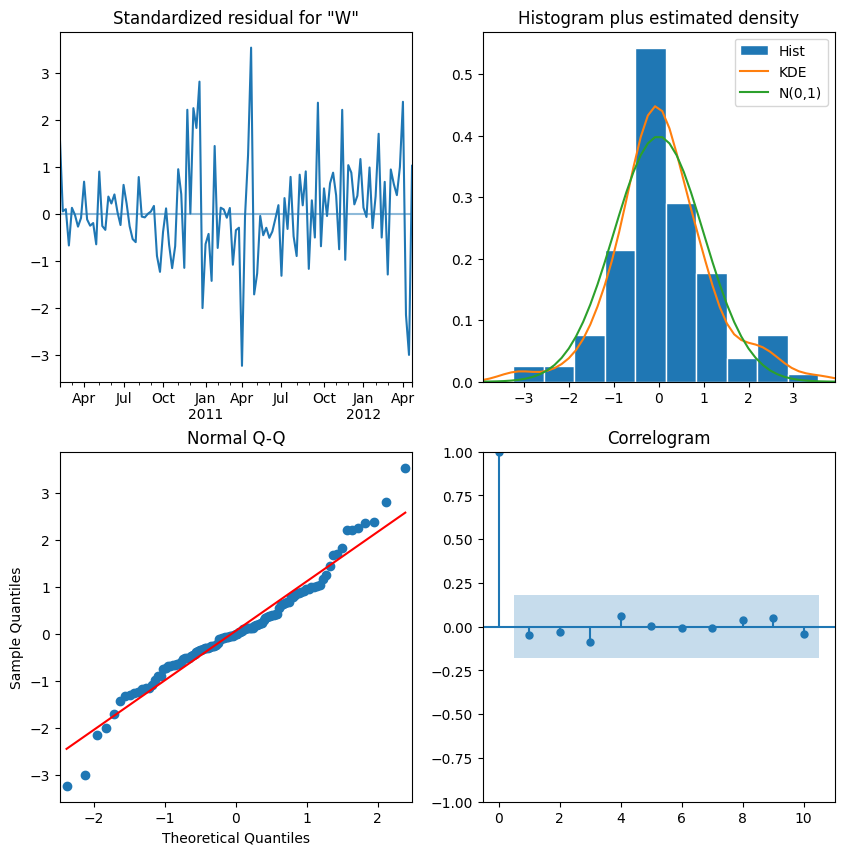

In [72]:
results.plot_diagnostics(figsize=(10,10))
plt.show()

**Standardized residuals plot:** The top left plot shows one-step-ahead standardized residuals. If our model is working correctly, there should be no obvious pattern in the residuals. This is shown here in this case.  
**Histogram plus estimated density plot:** This plot shows the distribution of the residuals. The histogram shows us the measured distribution; the orange line shows a smoothed version of this histogram, and the green line shows a normal distribution. If the model is good these two lines should be the same. Here there are little differences between them, which indicate that our model is doing great.  
**Normal Q-Q plot:** The Q-Q plot compare the distribution of the residuals to the normal distribution. If the distribution of the residuals is normal, then all the points should lie along the red line, except for some values at the end.  
**Correlogram plot:** The correlogram plot is the ACF plot of the residuals rather than the data. 95% of the correlations for lag greater than zero should not be significant (within the blue shades). If there is a significant correlation in the residuals, it means that there is information in the data that was not captured by the model.

### Predictions

In [73]:
#get the predictions and residuals
predictions = results.forecast(len(test))
predictions = pd.Series(predictions, index=test.index).to_frame(name='Weekly_Sales')
residuals = test - predictions

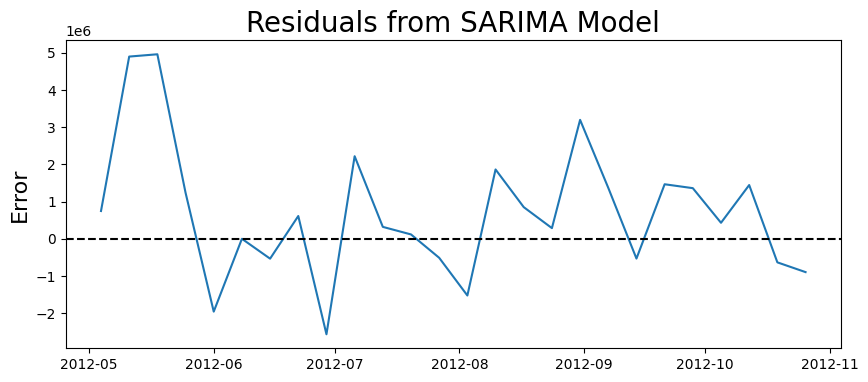

In [74]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title( 'Residuals from SARIMA Model' ,fontsize=20)
plt.ylabel( 'Error', fontsize=16)
plt.show()

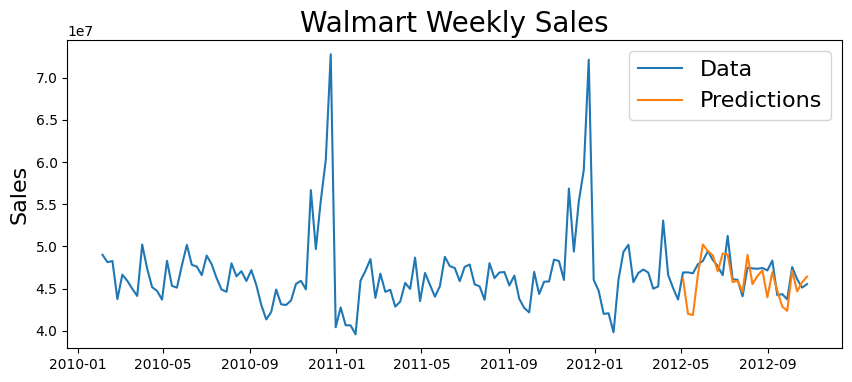

In [75]:
plt.figure(figsize=(10,4))
plt.plot(cum_pdf)
plt.plot(predictions)

plt.legend(('Data','Predictions'), fontsize=16)

plt.title('Walmart Weekly Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.show()

In [76]:
print('MAPE: ', round(np.mean(abs(residuals/test)),4))
# The mean absolute error
mae = np.mean(np.abs(residuals))
print("Mean Absolute Error: ", mae)
print('Root Mean Squared Error: ', round(np.sqrt(np.mean(residuals**2)),2))

MAPE:  Weekly_Sales    0.0299
dtype: float64
Mean Absolute Error:  Weekly_Sales    1.404961e+06
dtype: float64
Root Mean Squared Error:  Weekly_Sales    1895878.47
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In comparison to SARIMA model, the **XGBoost model performs much better** as it uses multidimentional data  